## The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

1. The samples are independent.

2. The dependent variable (weight) should be continuous.

3. The independent variables (gender, diet) should be two or more categorical groups.

4. Each sample (dependent variable) is from a normally distributed population.

4. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

5. If these assumptions are not true for a given set of data, it may still be possible to use the Kruskal-Wallis
   H-test (scipy.stats.kruskal) although with some loss of power.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import numpy as np

In [3]:
# it just happens to be a good style!
plt.style.use('fivethirtyeight')

# Diet Dataset, from https://ariepratama.github.io/How-to-Use-1-Way-Anova-in-Python/

For this problem purpose, hypothesis is:

"for each diet, mean of weight is same".

In [4]:
data = pd.read_csv('https://www.sheffield.ac.uk/polopoly_fs/1.570199!/file/stcp-Rdataset-Diet.csv')

Getting Sense of The Dataset

In [5]:
data.head()

,Person,gender,Age,Height,pre.weight,Diet,weight6weeks
0,25,,41,171,60,2,60.0
1,26,,32,174,103,2,103.0
2,1,0,22,159,58,1,54.2
3,2,0,46,192,60,1,54.0
4,3,0,55,170,64,1,63.3


In [6]:
print('This dataset contains {} rows'.format(data.size))

This dataset contains 546 rows


See If There is Any Missing Values

In [7]:
data.gender.unique()

array([' ', '0', '1'], dtype=object)

In [8]:
# show which person has the missing value in gender
data[data.gender == ' ']

,Person,gender,Age,Height,pre.weight,Diet,weight6weeks
0,25,,41,171,60,2,60.0
1,26,,32,174,103,2,103.0


In [19]:
print('Missing value percentage of all data: {:.2f}%'.format(data[data.gender == ' '].size / data.size * 100)) 
#upto 2 dec points

Missing value percentage of all data: 2.56%


we have 3% missing value, either we could ignore, delete, or classify it’s gender by using the closest weight mean.

Getting a visualization of the weight Distribution and check if they are normal distribution or not

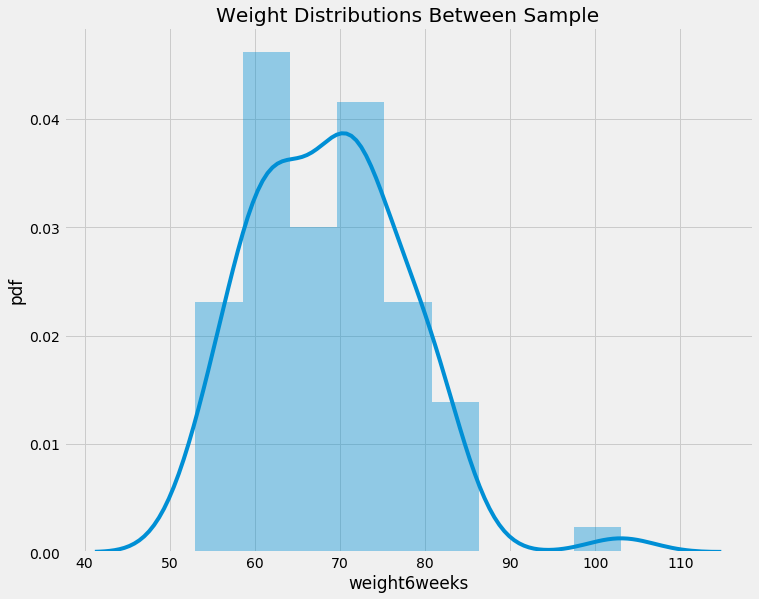

In [10]:
f, ax = plt.subplots(figsize=(11,9))
plt.title('Weight Distributions Between Sample')
plt.ylabel('pdf')
sns.distplot(data.weight6weeks)

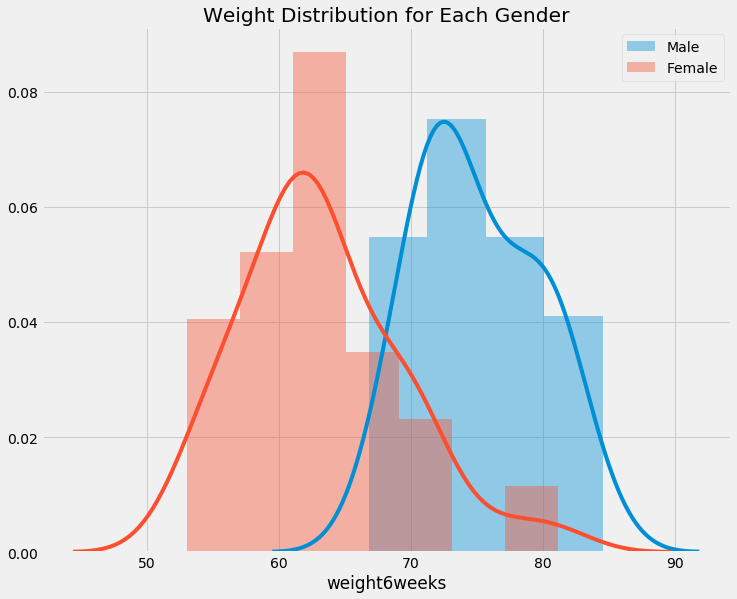

In [11]:
f, ax = plt.subplots(figsize=(11,9))
sns.distplot(data[data.gender == '1'].weight6weeks, ax=ax, label='Male')
sns.distplot(data[data.gender == '0'].weight6weeks, ax=ax, label='Female')
plt.title('Weight Distribution for Each Gender')
plt.legend()

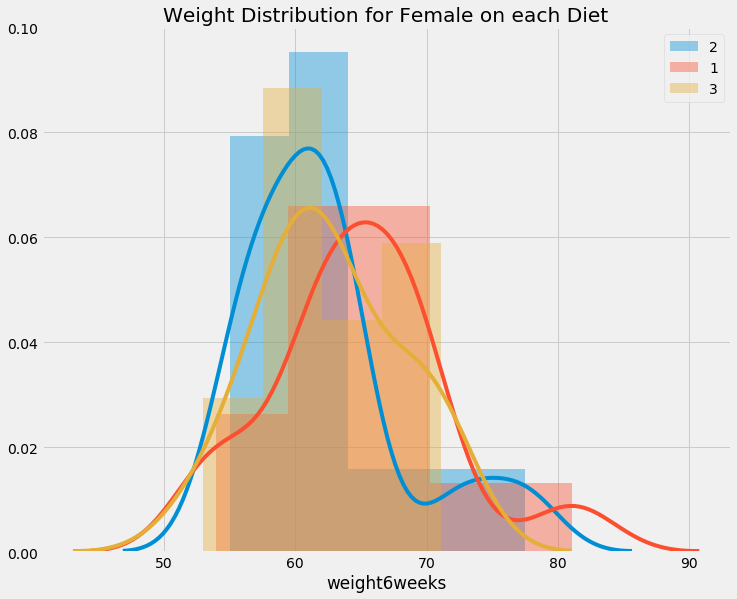

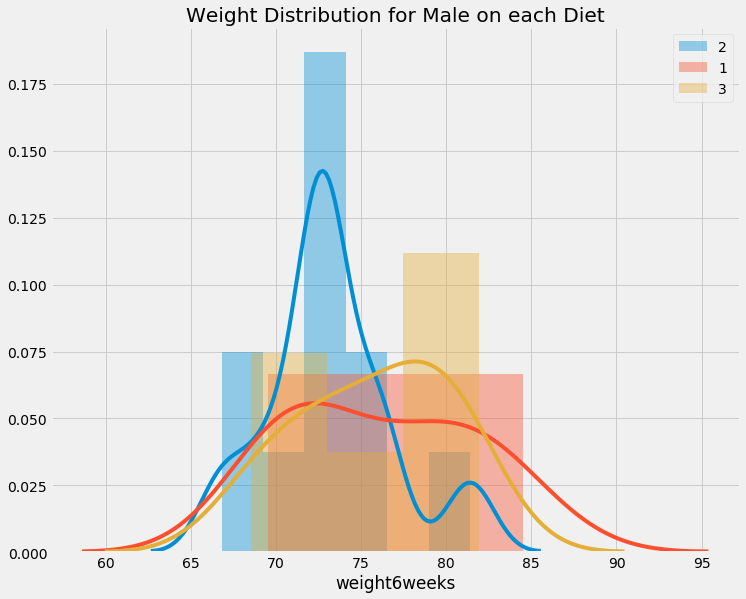

In [12]:
def infer_gender(x):
    if x == '1': 
        return 'Male'
    
    if x == '0':
        return 'Female'
    
    return 'Other'

def show_distribution(df, gender, column, group):
    f, ax = plt.subplots(figsize=(11,9))
    plt.title('Weight Distribution for {} on each {}'.format(gender, column))
    for group_member in group:
        sns.distplot(df[df[column] == group_member].weight6weeks, label='{}'.format(group_member))
    plt.legend()
    plt.show()
    
unique_diet = data.Diet.unique()
unique_gender = data.gender.unique()

for gender in unique_gender:
    if gender != ' ':
        show_distribution(data[data.gender == gender], infer_gender(gender), 'Diet', unique_diet)


In [13]:
data.groupby('gender').agg(
    [np.mean, np.median, np.count_nonzero, np.std]
).weight6weeks
# if we group them by gender we find 3 groups , one for males(1) and 2 different for females(0)

,mean,median,count_nonzero,std
gender,,,,
,81.500000,81.5,2.0,30.405592
0,63.223256,62.4,43.0,6.150874
1,75.015152,73.9,33.0,4.629398


In [14]:
data.groupby(['gender', 'Diet']).agg(
    [np.mean, np.median, np.count_nonzero, np.std]
).weight6weeks
# if we group them by gender and diet we observe that for males nearly all the groups have a similar mean and 
# one group in females have a mean deviating to a higher value

mean  median  count_nonzero        std
gender Diet                                             
       2     81.500000   81.50            2.0  30.405592
0      1     64.878571   64.50           14.0   6.877296
       2     62.178571   61.15           14.0   6.274635
       3     62.653333   61.80           15.0   5.370537
1      1     76.150000   75.75           10.0   5.439414
       2     73.163636   72.70           11.0   3.818448
       3     75.766667   76.35           12.0   4.434848

inference: We can see difference of weight in females based on different diet plans, but interestingly, it does not seem to affect males. 

Next question is: will the population behave the same?

The 1 Way Anova test tries to check, if it is true or not true
"for each diet, mean of weight is same"

let’s assume that we have initially determined our confidence level of 95%, which means that we will accept 5% error rate.

The third method of detremining Anova, using Statsmodels, is being used here. We start by using ordinary least squares method and then the anova_lm method. First, we import the api and the formula api. Second we, use ordinary least squares (ols) regression with our data. The object obtained is a fitted model that we later use with the anova_lm method to obtain ANOVA table.

In [15]:
mod = ols('Height ~ Diet', data=data[data.gender=='0']).fit()
# do type 2 anova
aov_table = sm.stats.anova_lm(mod, typ=2)
print('ANOVA table for Female')
print('----------------------')
print(aov_table)
print()


mod = ols('Height ~ Diet', data=data[data.gender=='1']).fit()
# do type 2 anova
aov_table = sm.stats.anova_lm(mod, typ=2)
print('ANOVA table for Male')
print('----------------------')
print(aov_table)

ANOVA table for Female
----------------------
               sum_sq    df        F    PR(>F)
Diet       559.680764   1.0  7.17969  0.010566
Residual  3196.086677  41.0      NaN       NaN

ANOVA table for Male
----------------------
               sum_sq    df        F    PR(>F)
Diet        67.801603   1.0  0.43841  0.512784
Residual  4794.259003  31.0      NaN       NaN


There are two p-values(PR(>F)) that we can see here, male and female.

For male, we cannot accept the null hypothesis under 95% confident level, because the p-value is greater than our alpha (0.05 < 0.512784). So given these three type of diet, there are no difference in male weights.

For female, since the p-value PR(>F) is less than our error rate (0.05 > 0.010566), we could reject the null hypothesis. This means we are quite confident that there is a different in weight for Females on different diet plans.

Okay so we know the effect of diet in female, but we don’t know which diet is different from which. We have to do post-hoc analysis using Tukey HSD (Honest Significant Difference) Test.

In [16]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

In [21]:
# Only use female data
df = data[data.gender=='0']

# compare the height between each diet, using 95% confidence interval 
mc = MultiComparison(df['Height'], df['Diet'])
tukey_result = mc.tukeyhsd(alpha=0.05)

print(tukey_result)
print('Unique diet groups: {}'.format(mc.groupsunique))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  1      2    -3.5714  -11.7861  4.6432 False 
  1      3    -8.7714  -16.848  -0.6948  True 
  2      3      -5.2   -13.2766  2.8766 False 
----------------------------------------------
Unique diet groups: [1 2 3]


We can only reject the null hypothesis between diet type 1 and diet type 3, means there is statistically significant difference in weight for diet 1 and diet 3.